In [1]:
import json
import networkx as nx
from typing import List

with open("openbb_functions_enum.json", "r") as f:
    openbb_functions = json.load(f)
with open("reference.json", "r") as f:
    data = json.load(f)
openbb_functions_name_dict = {k['name']:k for k in openbb_functions}

In [2]:
routers_names = [r.split("/")[1] for r in data['routers']]

In [3]:
all_functions = list(openbb_functions_name_dict.keys())

In [124]:
def get_graph(router_name:str):
    # print(router_name)
    desc = data['routers']['/'+router_name]

    # func_name = f'obb_{router_name}'
    path_name = "/" + router_name
    # req_func = [rf for rf in all_functions if rf.startswith(func_name)]
    req_data = [d for d in data['paths'] if d.startswith(path_name)]
    G = nx.DiGraph()

    G.add_nodes_from([(router_name,{"type":"level_1","description":desc['description']})])
    for rd in req_data:
        prev_node = router_name
        router_path_split = rd.split("/")[2:]
        trail = f"{router_name}"
        base_func_name = f"obb_{router_name}_" + "_".join(router_path_split)
        for idx,rps in enumerate(router_path_split):
            if idx == len(router_path_split)-1:
                # It has multiple providers
                if base_func_name in openbb_functions_name_dict:
                    standard_func_params = openbb_functions_name_dict[base_func_name]
                    if not G.has_node(rps):
                        G.add_nodes_from([(rps,{"type":f"level_{idx+2}","description":standard_func_params['description'],"trail":trail,'peanultimate_node':True})])
                        G.add_edge(prev_node,rps)
                    # trail += f"-->{rps}"
                    all_providers = standard_func_params['parameters']['properties']['provider']['enum']
                    for provider in all_providers:
                        provider_func_name = base_func_name + "_" + provider
                        provider_func_params = openbb_functions_name_dict[provider_func_name]
                        G.add_nodes_from([(provider_func_name,{"type":f"provider_function","function_call":provider_func_params,"trail":f"{trail}-->{rps}","provider_source":provider})])
                        G.add_edge(rps,provider_func_name)
                else:
                    # trail += f"-->{rps}"
                    for obb_funcs in openbb_functions_name_dict:
                        if base_func_name in obb_funcs:
                            provider_func = openbb_functions_name_dict[obb_funcs]
                            if not G.has_node(rps):
                                G.add_nodes_from([(rps,{"type":f"level_{idx+2}","description":provider_func['description'],"trail":trail,'peanultimate_node':True})])
                                G.add_edge(prev_node,rps)
                            provider = obb_funcs.rpartition("_")[-1]
                            G.add_nodes_from([(obb_funcs,{"type":f"provider_function","function_call":provider_func,"trail":f"{trail}-->{rps}","provider_source":provider})])
                            G.add_edge(rps,obb_funcs)
                            break
            else:
                if not G.has_node(rps):
                    G.add_nodes_from([(rps,{"type":f"level_{idx+2}","description":data['paths'][rd]['description'],"trail":trail,'peanultimate_node':False})])
                    G.add_edge(prev_node,rps)
                trail += f"-->{rps}"
                prev_node = rps
    return G
router_names_graph = {k:get_graph(k) for k in routers_names}
# from networkx.drawing.nx_agraph import graphviz_layout
# import matplotlib.pyplot as plt
# pos = graphviz_layout(router_names_graph['derivatives'], prog="dot")
# plt.figure(figsize=(20, 10))
# nx.draw(router_names_graph['derivatives'], pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, arrows=True)
# # plt.title(f"{router.capitalize()}")
# plt.show()

In [125]:
# for node,attributes in router_names_graph['equity'].nodes(data=True):
#     # print(attributes)
#     if 'trail' in attributes and attributes['trail'].startswith('equity'):
#         print(attributes['trail'])

In [126]:
import ast
embed_docs = []
embed_metadata = []
non_embed_docs =[]
non_embed_metadata = []
for router_name,router_graph in router_names_graph.items():
    for node,attributes in router_graph.nodes(data=True):
        if attributes['type'].startswith("level"):
            embed_docs.append(attributes['description'])
            attributes.update({"node_name":node})
            for key,value in attributes.items():
                if isinstance(value,dict):
                    attributes[key] = str(value)
                else:
                    pass
            embed_metadata.append(attributes)
        else:
            if 'description' in attributes:
                non_embed_docs.append(attributes['description'])
            else:
                non_embed_docs.append("empty")
            attributes.update({"node_name":node})
            for key,value in attributes.items():
                if isinstance(value,dict):
                    attributes[key] = str(value)
                else:
                    pass
            non_embed_metadata.append(attributes)

docs = embed_docs + non_embed_docs
metadata = embed_metadata + non_embed_metadata

In [127]:
metadata[100]

{'type': 'level_2',
 'description': 'ETF Information Overview.',
 'trail': 'etf',
 'peanultimate_node': True,
 'node_name': 'info'}

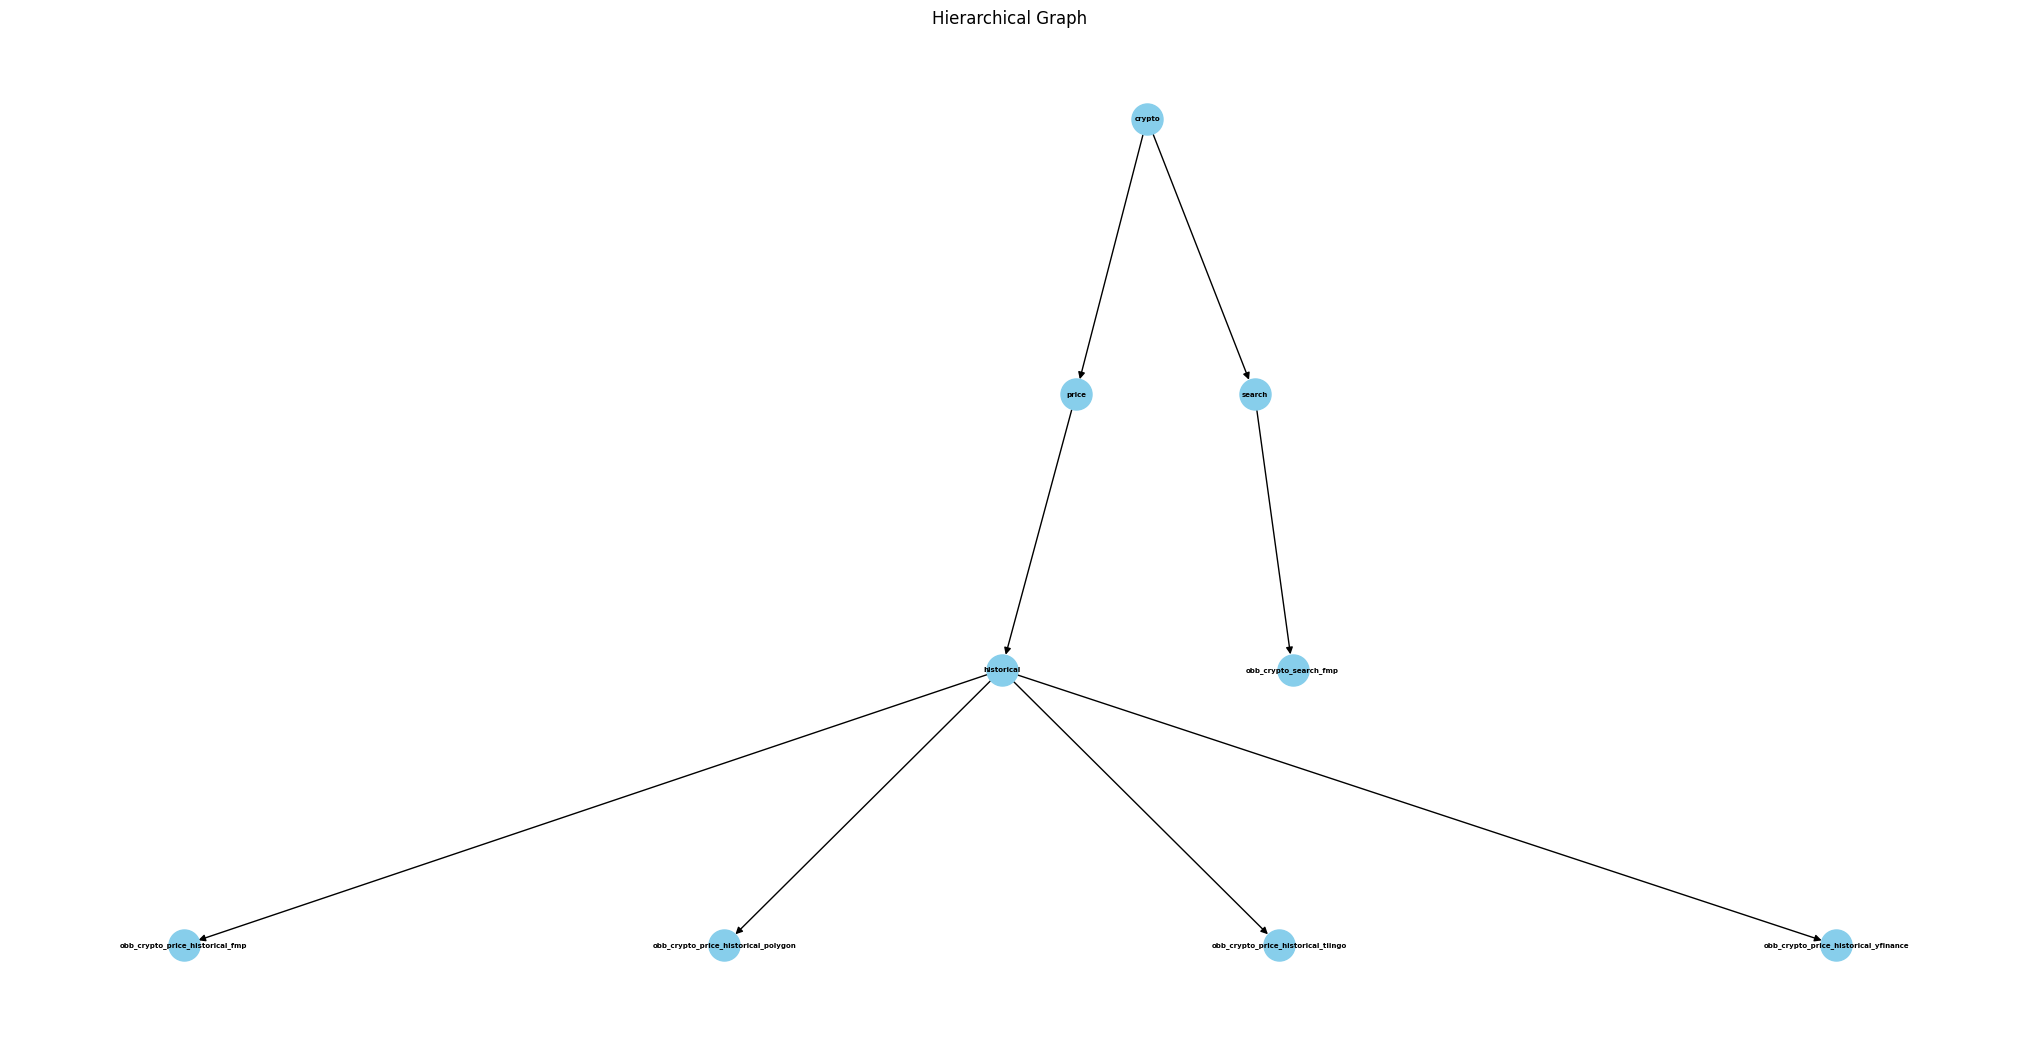

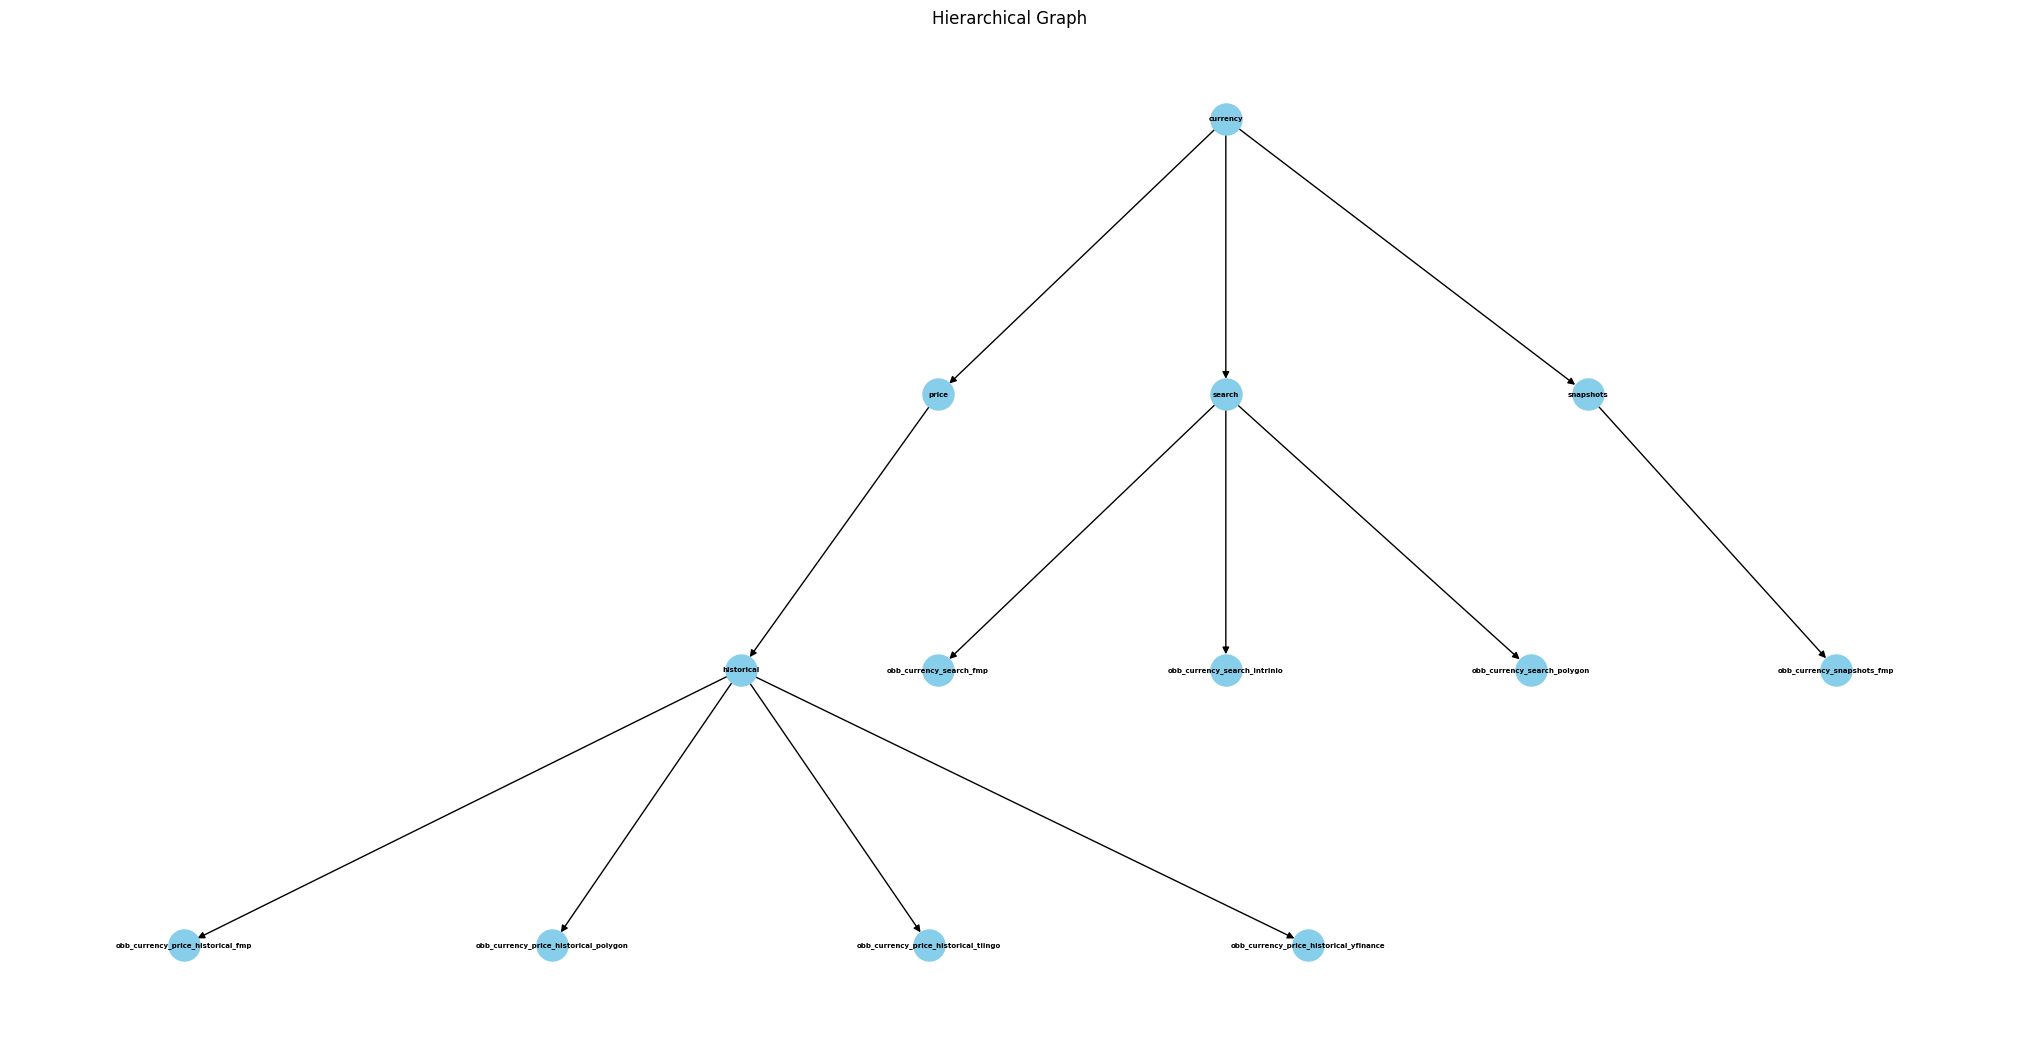

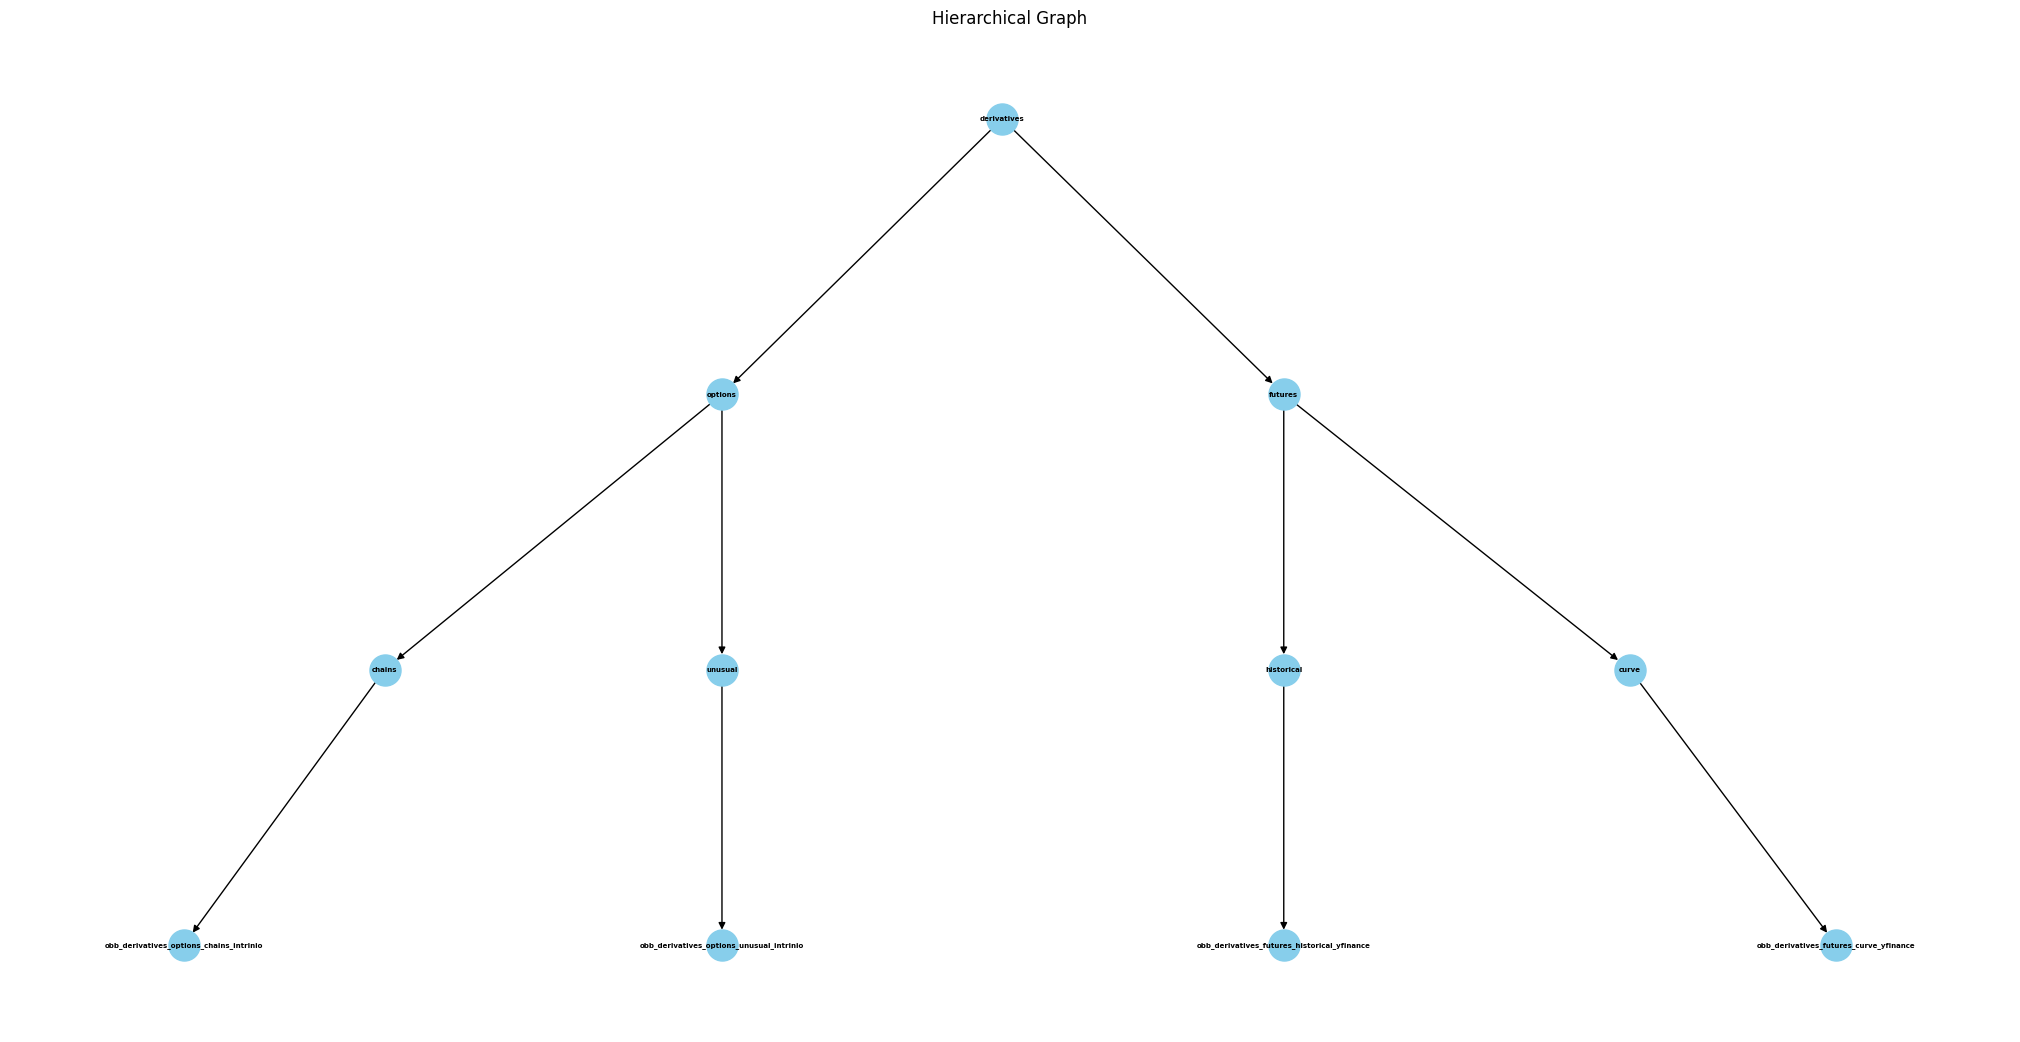

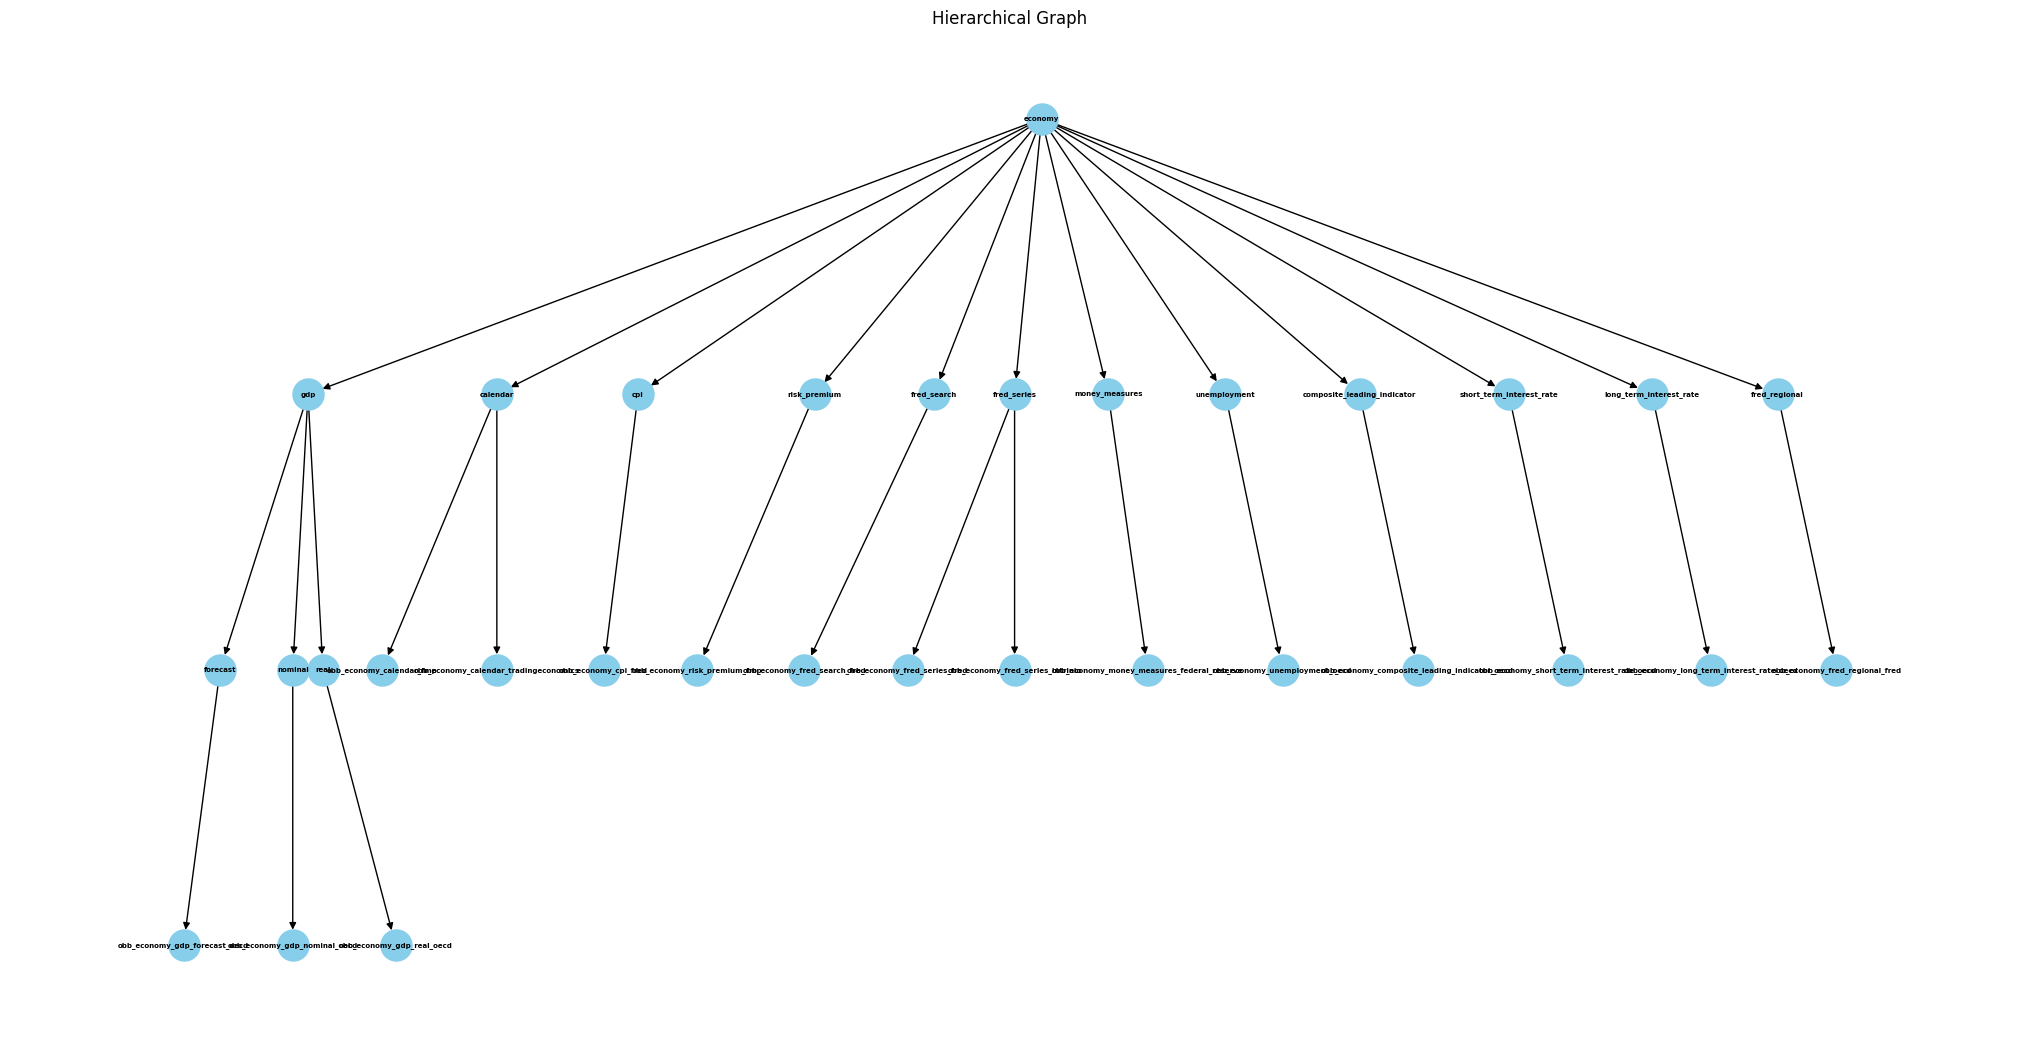

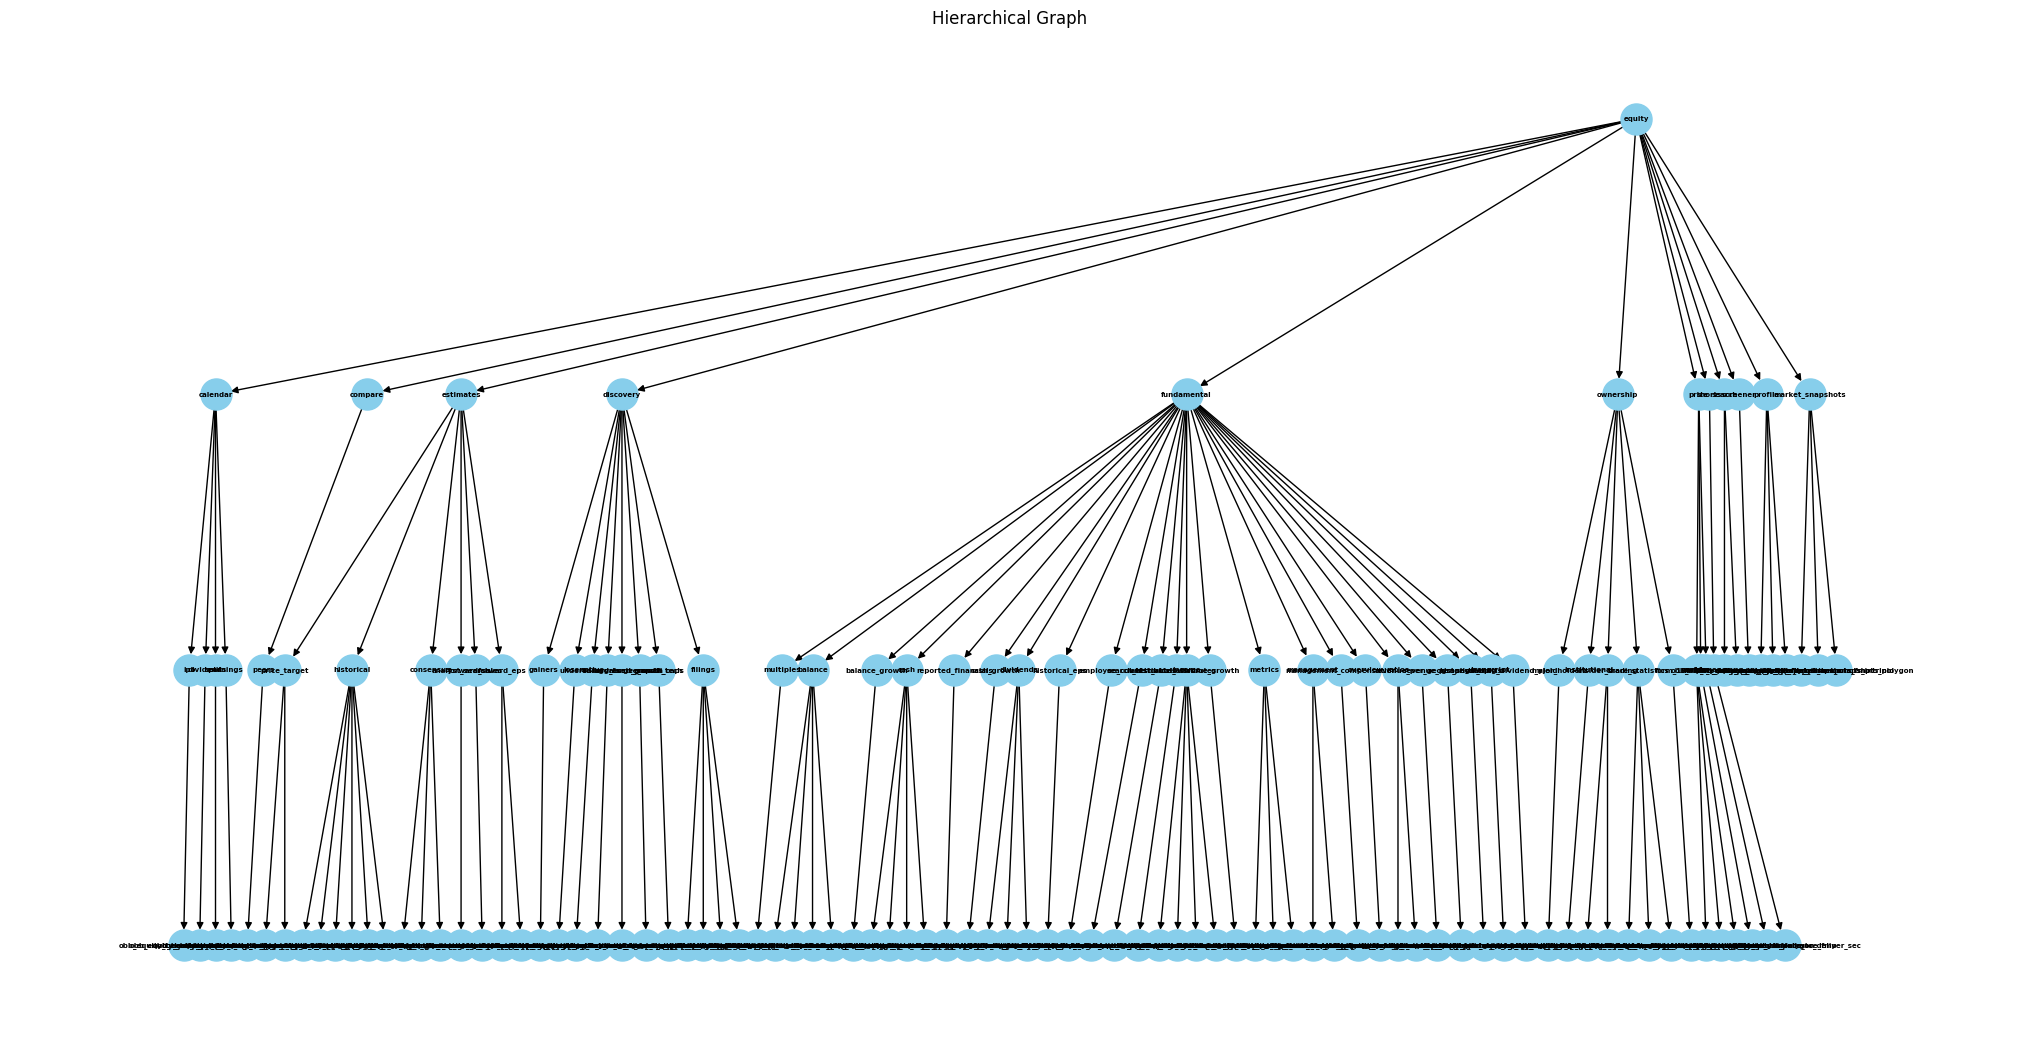

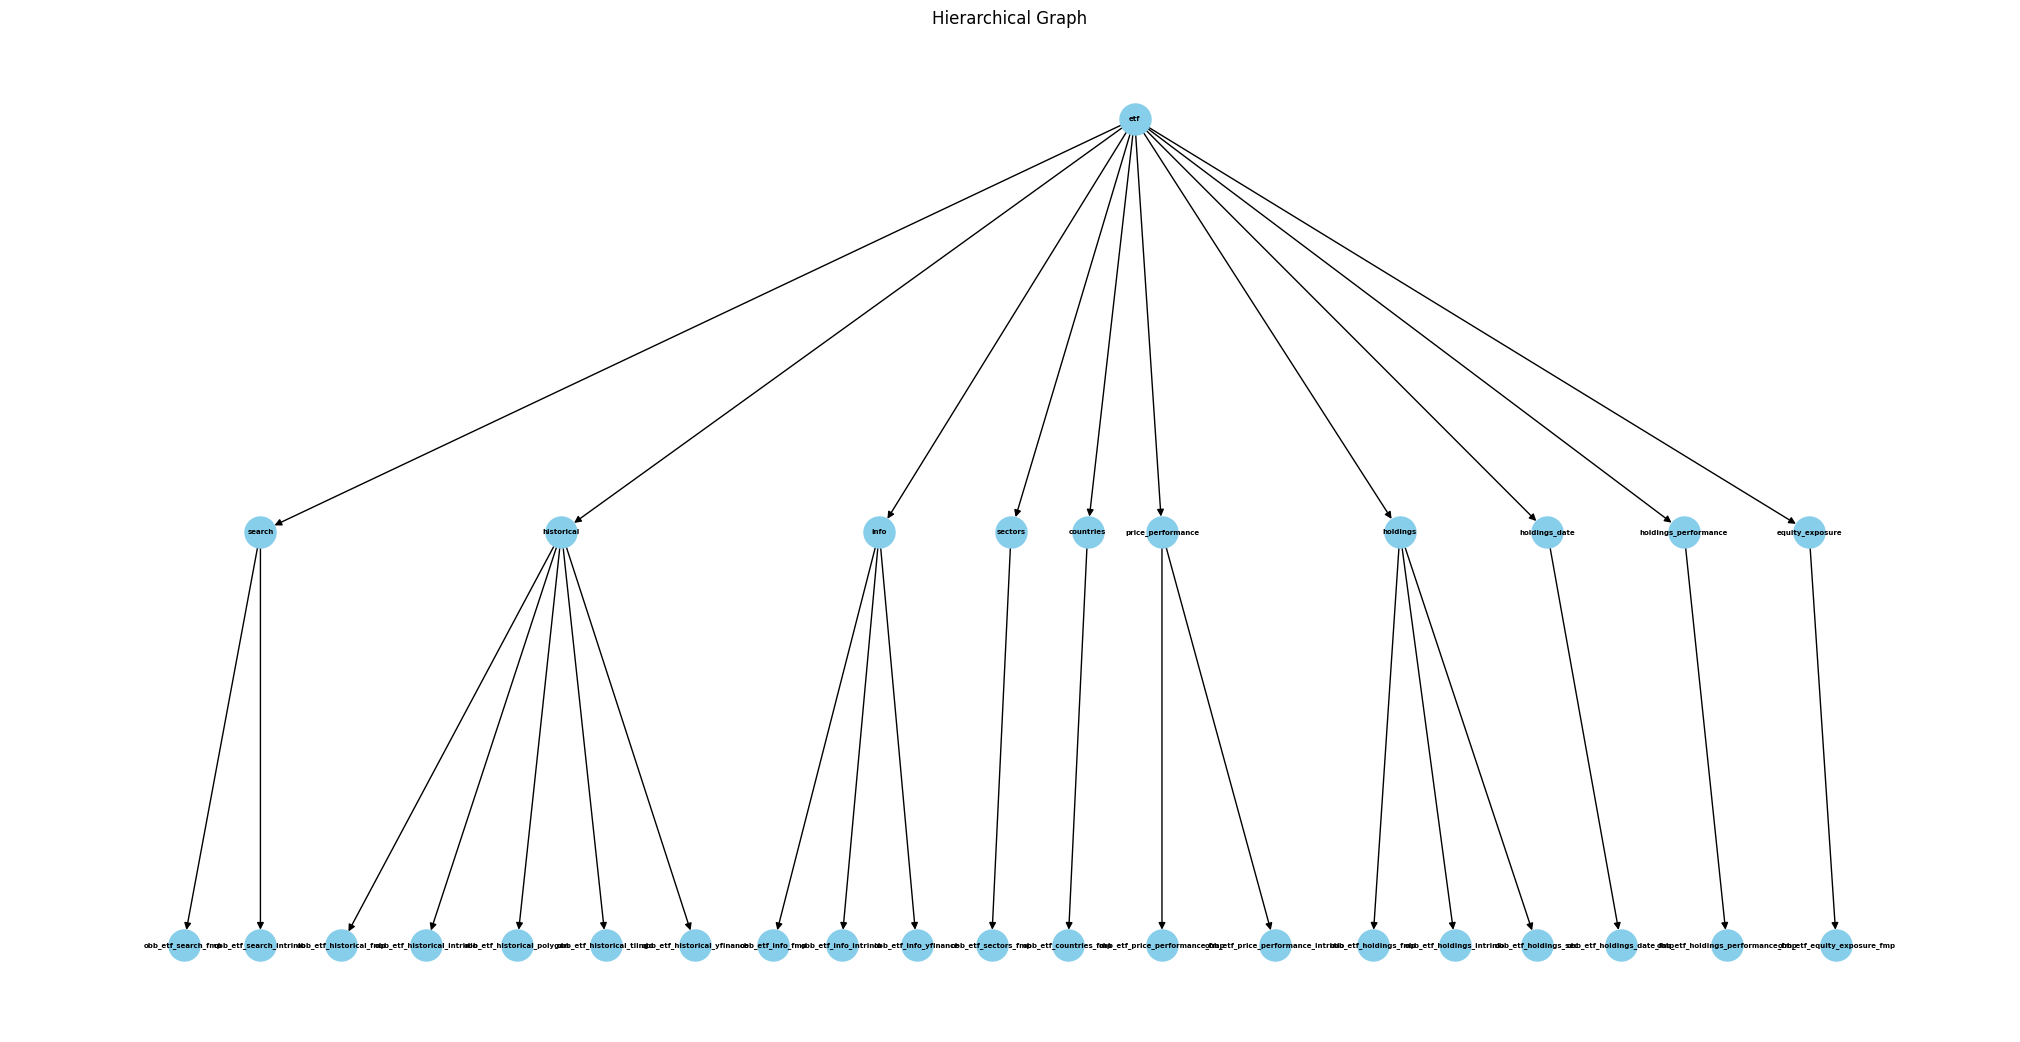

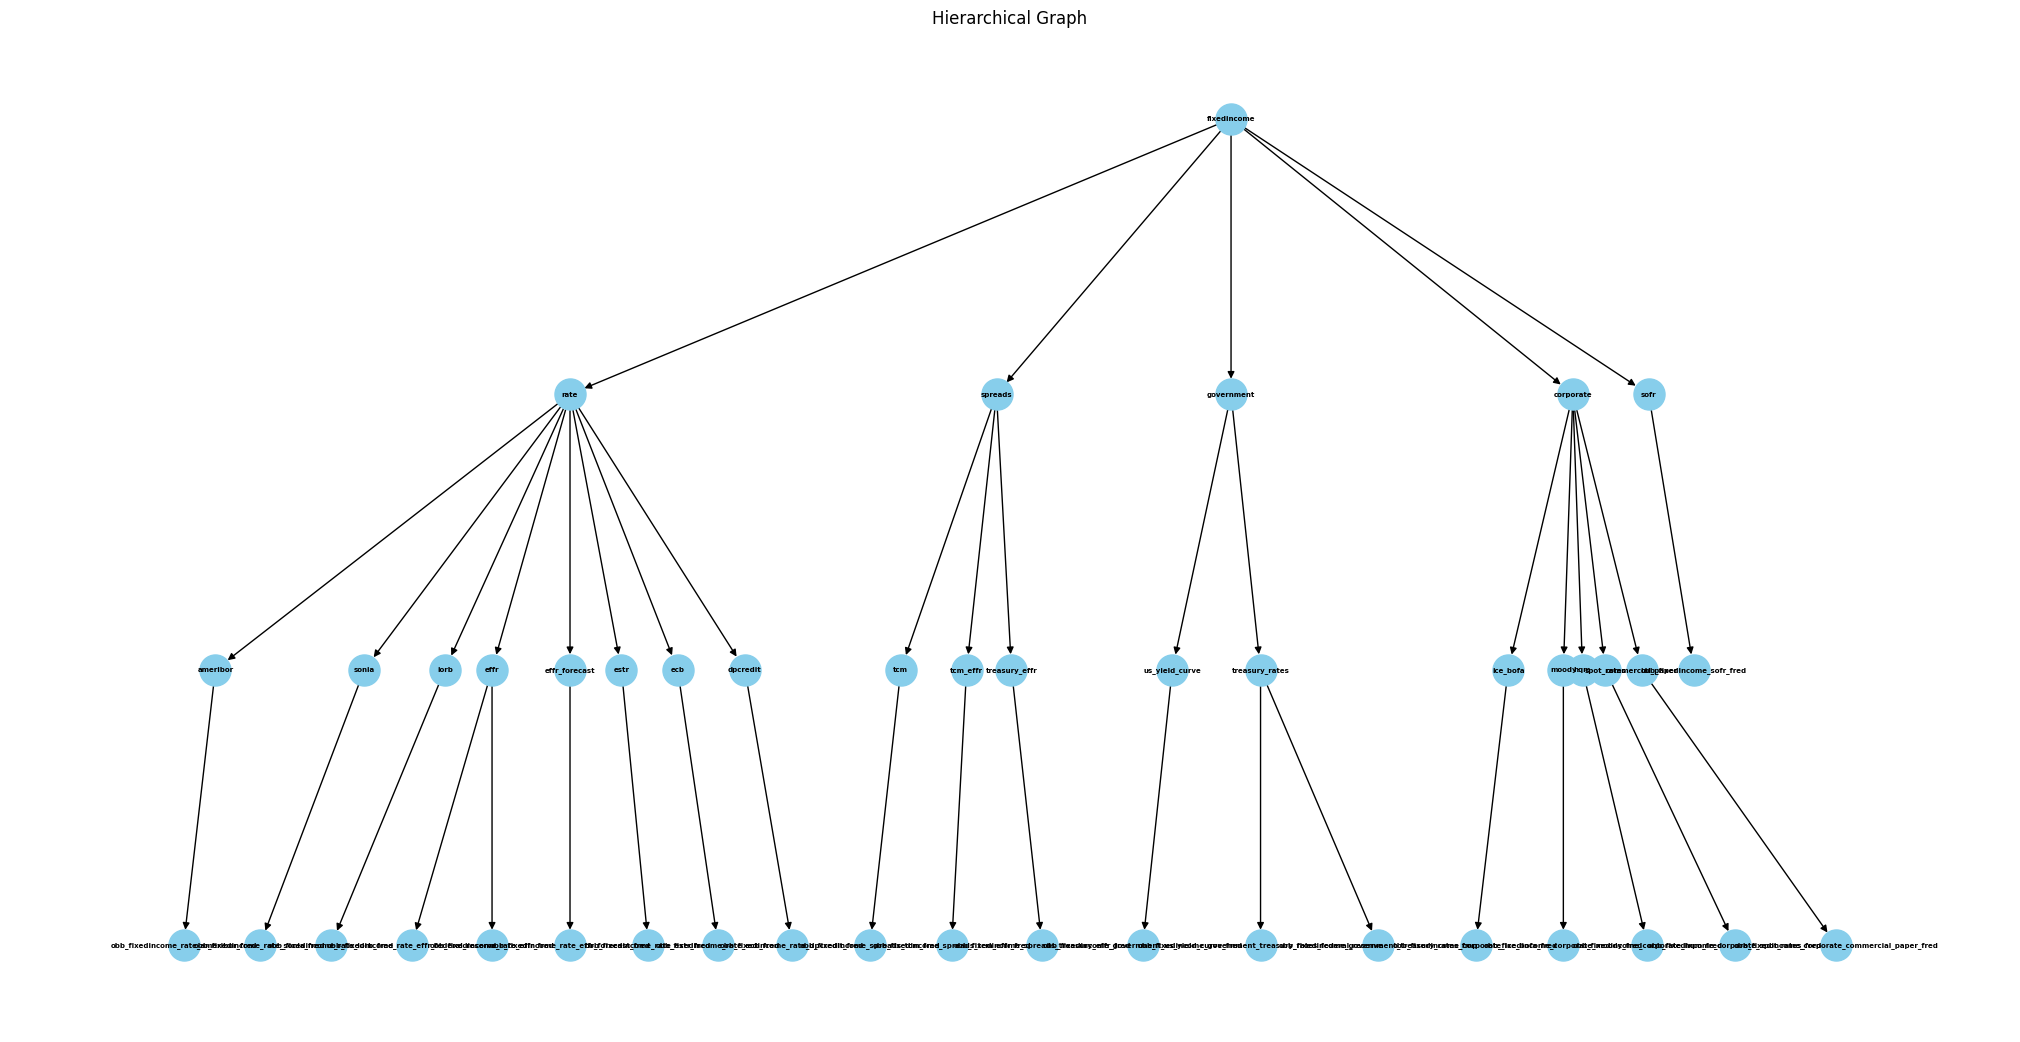

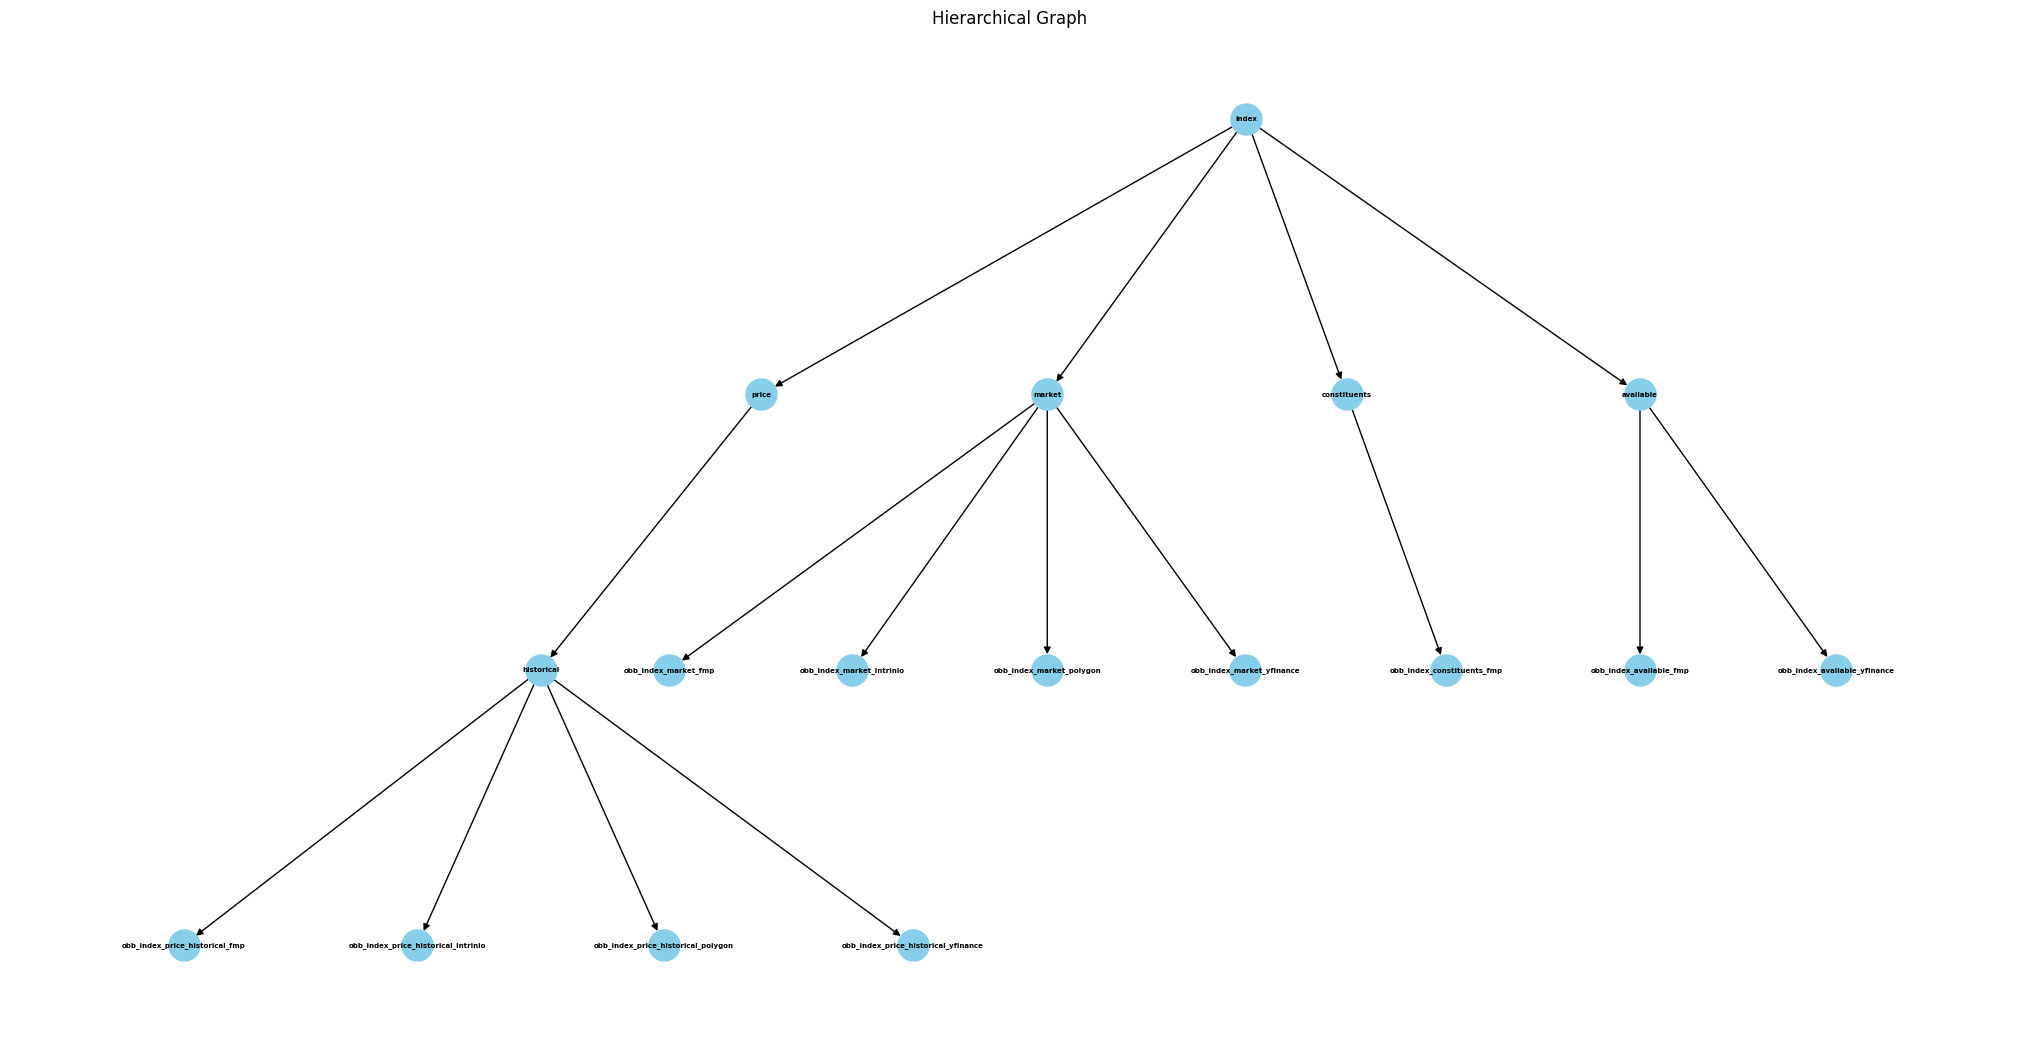

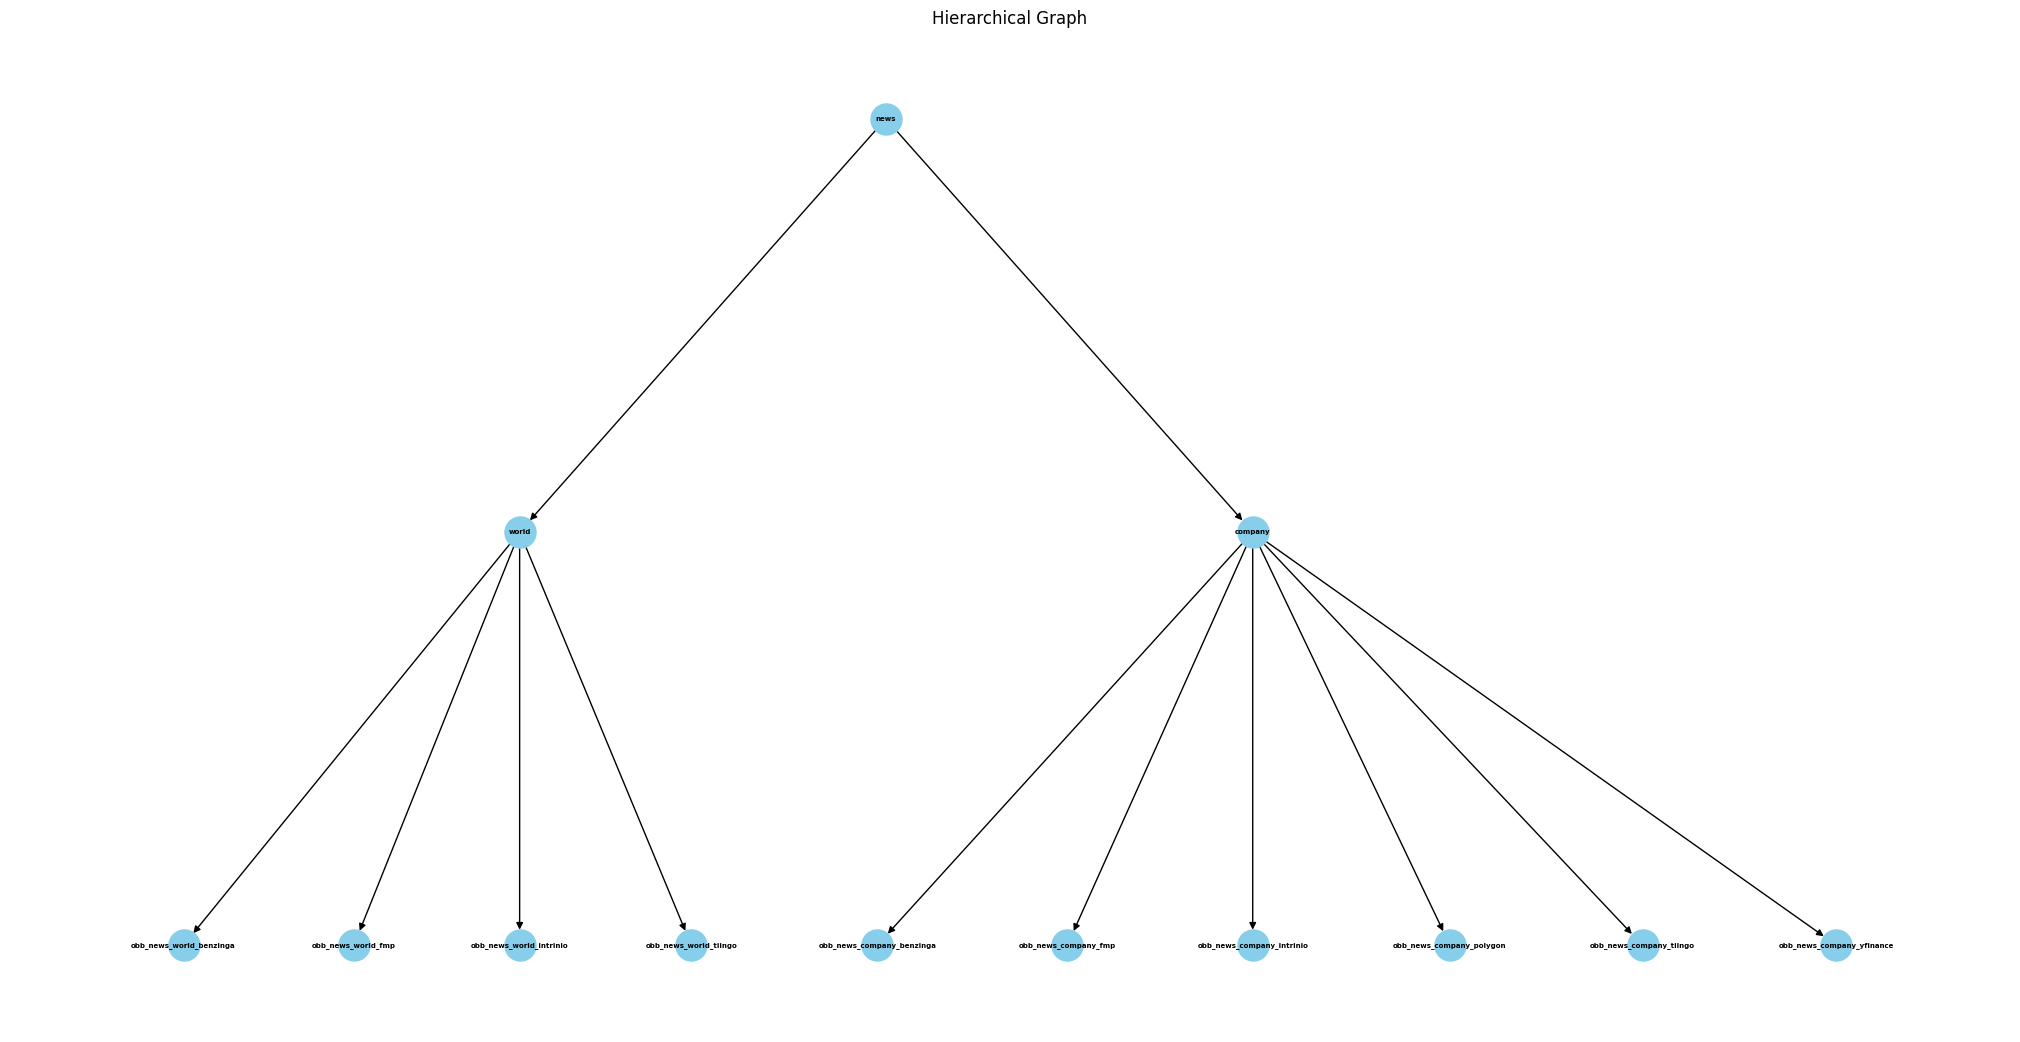

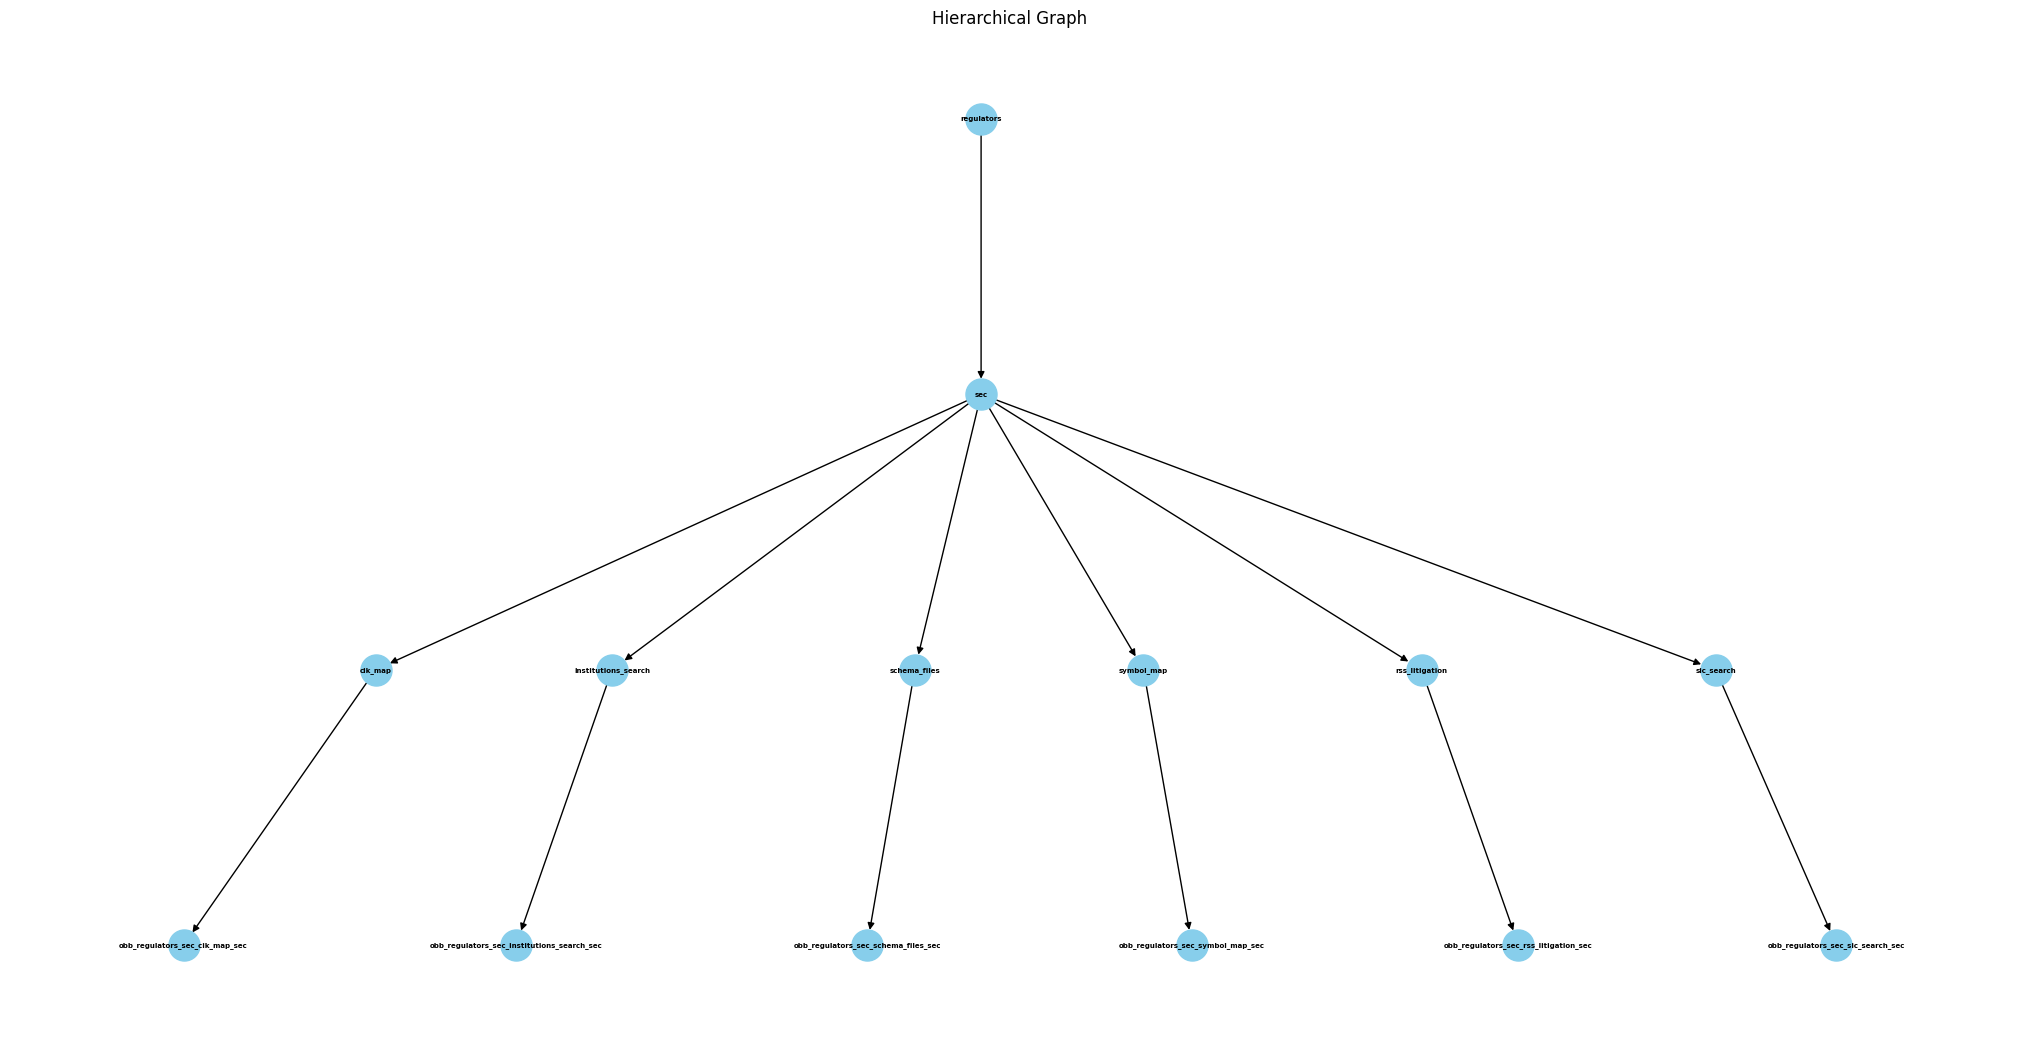

In [82]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
for router in routers_names:
    graph = router_names_graph[router]
    pos = graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(20, 10))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, font_weight="bold", arrows=True)
    plt.title("Hierarchical Graph")
    plt.show()

In [128]:
G = router_names_graph['crypto']

In [129]:
for node, attributes in G.nodes(data=True):
    print("Node:", node)
    print("Attributes:", attributes)

Node: crypto
Attributes: {'type': 'level_1', 'description': 'Cryptocurrency market data.', 'node_name': 'crypto'}
Node: price
Attributes: {'type': 'level_2', 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.', 'trail': 'crypto', 'peanultimate_node': False, 'node_name': 'price'}
Node: historical
Attributes: {'type': 'level_3', 'description': 'Get historical price data for cryptocurrency pair(s) within a provider.', 'trail': 'crypto-->price', 'peanultimate_node': True, 'node_name': 'historical'}
Node: obb_crypto_price_historical_fmp
Attributes: {'type': 'provider_function', 'function_call': '{\'name\': \'obb_crypto_price_historical_fmp\', \'description\': \'Get historical price data for cryptocurrency pair(s) within a provider. Get it from provider fmp\', \'parameters\': {\'type\': \'object\', \'properties\': {\'symbol\': {\'type\': \'string\', \'description\': \'Symbol to get data for. Can use CURR1-CURR2 or CURR1CURR2 format. Multiple items allowed

In [130]:
len(docs),len(metadata)

(343, 343)

In [131]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
import os
from chromadb.utils.batch_utils import create_batches

from dotenv import load_dotenv
load_dotenv(override=True)
emb_fn = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ['OPENAI_API_KEY'],
                model_name="text-embedding-3-small")
collection_name = "obb_docs"
client = chromadb.PersistentClient(path="OpenBBdb")
try:
    if client.get_collection(name=collection_name):
        client.delete_collection(name=collection_name)
except: pass
openbb_collection = client.create_collection(name=collection_name,embedding_function=emb_fn)

openbb_ids = [f"id{i}" for i in range(len(docs))]
batches = create_batches(api=client,ids=openbb_ids, documents=docs, metadatas=metadata)
for batch in batches:
    openbb_collection.add(ids=batch[0],
                documents=batch[3],
                metadatas=batch[2])

In [2]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
import os
from chromadb.utils.batch_utils import create_batches

from dotenv import load_dotenv
collection_name = "obb_docs"
load_dotenv(override=True)
emb_fn = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ['OPENAI_API_KEY'],
                model_name="text-embedding-3-small")
client = chromadb.PersistentClient(path="OpenBBdb")
openbb_collection = client.get_collection(name=collection_name,embedding_function=emb_fn)

In [3]:
openbb_collection

Collection(name=obb_docs)

In [4]:
import dspy

first_level_llm = dspy.OpenAI(model='gpt-3.5-turbo-1106',max_tokens=1024)
second_level_llm = dspy.OpenAI(model='gpt-3.5-turbo-1106',max_tokens=1024)
function_calling_llm = dspy.OpenAI(model='gpt-3.5-turbo-1106',max_tokens=1024)

/home/athekunal/Function Calling/openbb-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BM25 RETRIEVER

## TASKS TODAY
1. TRAIL LIST
2. GET THE AGENT WORKING TO GET THE FUNCTION CALL
3. FUNCTION CALL INTEGRATION

In [5]:
def generate_pairs(list1,list2):
    pairs = []
    for l1 in list1:
        for l2 in list2:
            curr_trail = l1
            curr_trail+=f"-->{l2}"
            pairs.append(curr_trail)
    return [pairs]

def generate_pairs_recursive(trail_list):
    if len(trail_list) ==1:
        return trail_list[0]
    curr_pairs = generate_pairs(trail_list[-2],trail_list[-1])
    modified_trail_list = trail_list[:-2] + curr_pairs
    return generate_pairs_recursive(modified_trail_list)

In [20]:
class FirstSecondLevel(dspy.Signature):
    """You are given a list of keys and values separated by semicolon. 
    Based on the query, you have to output the key that is most relevant to the question.
    Be precise and output only the relevant key or keys.
    Don't include any other information
    """
    query = dspy.InputField(prefix="Query which you need to classify: ",format=str)
    keys_values = dspy.InputField(prefix="Keys and Values: ",format=str)
    output = dspy.OutputField(prefix="Relevant Key(s): ",format=str,desc="relevant keys separated by ;")

def get_trail_list_pairs(trail_list_pairs):
    if len(trail_list_pairs) == 1:
        trail_where_clause = {
                    "trail": {
                        "$eq": trail_list_pairs[0]
                    }
                }
    elif len(trail_list_pairs)>1:
        trail_where_clause = {
            "$or": [{"trail":{"$eq":t}} for t in trail_list_pairs]
        }
    return trail_where_clause
# class SecondLevel(dspy.Signature):
dspy.settings.configure(lm=first_level_llm)

class OpenBBAgentChroma(dspy.Module):
    """OpenBB Agent for function calling"""
    def __init__(self,collection):
        """Init function for OpenBB agent
        """
        super(OpenBBAgentChroma,self).__init__()
        self.collection = collection
        get_first_level = self.collection.get(where={"type":"level_1"})
        self.first_level = ""
        for first_level_metadata in get_first_level['metadatas']:
            
            self.first_level += f"{first_level_metadata['node_name']}: {first_level_metadata['description']}\n"
        self.firstSecondLevel = dspy.ChainOfThought(FirstSecondLevel)

    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)
    
    def forward(self,query:str):
        function_calls_list = []
        question_emb = emb_fn([query])[0]
        first_level_answer = self.firstSecondLevel(query=query,keys_values=self.first_level)
        print(first_level_answer)
        first_level_answer = first_level_answer.output
        if ";" in first_level_answer:
            # ['crypto','index']
            trail_list = [[fla.strip() for fla in first_level_answer.split(";")]]
            
        else:
            trail_list = [[first_level_answer]]
        curr_level = 2
        while True:
            # if curr_level>3: break
            trail_list_pairs = generate_pairs_recursive(trail_list)
            print(trail_list_pairs)
            
            trail_where_clause = get_trail_list_pairs(trail_list_pairs)
            subsequent_level = self.collection.query(
                query_embeddings = question_emb,
                where = {
                    "$and":[
                        trail_where_clause,
                        {
                            "type": {
                                "$eq": f"level_{curr_level}"
                            }
                        }
                    ]
                },
                n_results = 5
            )
            # If subsequent level metadata has only element 
            if len(subsequent_level['metadatas'][0]) == 1 or curr_level>3: 
                if curr_level > 3:
                    if len(function_calls_list) == 0:
                        function_calls_list.append(subsequent_level['metadatas']['function_call'])
                    return function_calls_list
                curr_trail = f"{subsequent_level['metadatas'][0][0]['trail']}-->{subsequent_level['metadatas'][0][0]['node_name']}"
                # with peanultimate node as True
                # If peanultimate node is False, then loop again
                if subsequent_level['metadatas'][0][0]['peanultimate_node'] == True:
                    function_call = self.collection.get(
                        where = {
                        "$and":[
                            {
                                "type": {
                                    "$eq": "provider_function"
                                }
                            },
                            {
                                "trail":{
                                    "$eq":curr_trail
                                }
                            }
                        ]
                    })
                    function_calls_list.append(function_call['metadatas'])
                    return function_calls_list
                else:
                    trail_list.append([subsequent_level['metadatas'][0][0]['node_name']])
                    curr_level+=1
            elif len(subsequent_level['metadatas'][0])>1:
                curr_trail_list = []
                subsequent_level_str = ""
                peanultimate_node_dict = {}
                for subsequent_level_metadata in subsequent_level['metadatas'][0]:
                    if subsequent_level_metadata['peanultimate_node']:
                        function_call = self.collection.get(
                            where = {
                            "$and":[
                                {
                                    "type": {
                                        "$eq": "provider_function"
                                    }
                                },
                                {
                                    "trail":{
                                        "$eq":f"{subsequent_level_metadata['trail']}-->{subsequent_level_metadata['node_name']}"
                                    }
                                }
                            ]
                        })
                        peanultimate_node_dict.update({subsequent_level_metadata['node_name']:function_call})
                        if curr_trail_list == []:
                            curr_trail_list.append([subsequent_level_metadata['node_name']])
                        else:
                            curr_trail_list[-1].append(subsequent_level_metadata['node_name'])
                    subsequent_level_data = subsequent_level_metadata['description'].replace('\n\n', '').replace('\n', '')
                    subsequent_level_str += f"{subsequent_level_metadata['node_name']}: {subsequent_level_data}\n\n"
                print(subsequent_level_str)
                if subsequent_level_str != '':
                    subsequent_level_answer = self.firstSecondLevel(query=query,keys_values=subsequent_level_str)
                    print(subsequent_level_answer)
                    splitted_subsequent_level_answer = subsequent_level_answer.output.split(";")
                    if curr_trail_list == []:
                        curr_trail_list.append([sl.strip() for sl in splitted_subsequent_level_answer])
                    else:
                        curr_trail_list[-1].extend([sl.strip() for sl in splitted_subsequent_level_answer])
                for node_name in peanultimate_node_dict:
                    function_val = peanultimate_node_dict[node_name]
                    if node_name in splitted_subsequent_level_answer:
                        if function_val!=[]:
                            function_calls_list.append(peanultimate_node_dict[node_name])
                    else:
                        curr_trail_list[-1].remove(node_name)
                # print(curr_trail_list)
                curr_trail_list[-1] = list(set(curr_trail_list[-1]))
                trail_list.extend(curr_trail_list)
                curr_level+=1
            else:
                break
        return function_calls_list
    
openbb_agent = OpenBBAgentChroma(openbb_collection)
fcs = openbb_agent("What is the global news data from Benzinga?")
# fcs = openbb_agent("What is historical equity estimates of Amazon?")
# fcs = openbb_agent("What is historical earnings per share of Apple?")
# fcs
# fcs = openbb_agent("What is the historical price of Ethereum?")

Prediction(
    rationale='produce the output. We are looking for global news data, so the most relevant key is "news".',
    output='news'
)
['news']
world: World News. Global news data.

company: Company News. Get news for one or more companies.


Prediction(
    rationale='produce the output. We need to find the key that is most relevant to global news data from Benzinga.',
    output='world'
)
['news-->world']


In [21]:
fcs

[{'ids': ['id327', 'id328', 'id329', 'id330'],
  'embeddings': None,
  'metadatas': [{'function_call': '{\'name\': \'obb_news_world_benzinga\', \'description\': \'World News. Global news data. Get it from provider benzinga\', \'parameters\': {\'type\': \'object\', \'properties\': {\'limit\': {\'type\': \'integer\', \'description\': \'The number of data entries to return. The number of articles to return.\', \'default\': 2500}, \'start_date\': {\'type\': \'string\', \'description\': \'Start date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'end_date\': {\'type\': \'string\', \'description\': \'End date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'provider\': {\'description\': "The provider to use for the query, by default None. If None, the provider specified in defaults is selected or \'benzinga\' if there is no default.", \'default\': \'benzinga\', \'type\': \'string\', \'enum\': [\'benzinga\']}, \'date\': {\'name\': \'date\', \'type\': \'string\', \'descr

In [10]:
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document
class FirstSecondLevel(dspy.Signature):
    """You are given a list of keys and values separated by semicolon. 
    Based on the query, you have to output the key that is most relevant to the question.
    You have to choose the most relevant key or keys from the given set of keys.
    Output only the relevant key or keys.
    Don't include any other information
    """
    query = dspy.InputField(prefix="Query which you need to classify: ",format=str)
    keys_values = dspy.InputField(prefix="Keys and Values: ",format=str)
    output = dspy.OutputField(prefix="Relevant Key(s): ",format=str,desc="relevant keys separated by ;")

def get_trail_list_pairs(trail_list_pairs):
    if len(trail_list_pairs) == 1:
        trail_where_clause = {
                    "trail": {
                        "$eq": trail_list_pairs[0]
                    }
                }
    elif len(trail_list_pairs)>1:
        trail_where_clause = {
            "$or": [{"trail":{"$eq":t}} for t in trail_list_pairs]
        }
    return trail_where_clause
# class SecondLevel(dspy.Signature):
dspy.settings.configure(lm=first_level_llm)

class OpenBBAgentBM25(dspy.Module):
    """OpenBB Agent for function calling"""
    def __init__(self,collection):
        """Init function for OpenBB agent
        """
        super(OpenBBAgentBM25,self).__init__()
        self.collection = collection
        get_first_level = self.collection.get(where={"type":"level_1"})
        self.first_level = ""
        for first_level_metadata in get_first_level['metadatas']:
            
            self.first_level += f"{first_level_metadata['node_name']}: {first_level_metadata['description']}\n"
        self.firstSecondLevel = dspy.ChainOfThought(FirstSecondLevel)

    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)
    
    def BM25RetrieverLangchain(self,question:str,trail_where_clause,curr_level:int):
        if curr_level>3:
            vectordb_docs = self.collection.get(
                            where = {
                        "$and":[
                            trail_where_clause,
                            {
                                "type": {
                                    "$eq": "provider_function"
                                }
                            }
                        ]
                    })
            langchain_docs = []
            # print(vectordb_docs)
            if len(vectordb_docs['metadatas']) == 0:
                return [Document(page_content="")]
            for data in vectordb_docs['metadatas']:
                # print(data)
                langchain_docs.append(Document(page_content="empty",metadata=data))
        else:
            vectordb_docs = self.collection.get(
                            where = {
                        "$and":[
                            trail_where_clause,
                            {
                                "type": {
                                    "$eq": f"level_{curr_level}"
                                }
                            }
                        ]
                    })
            langchain_docs = []
            # print(vectordb_docs)
            if len(vectordb_docs['metadatas']) == 0:
                return [Document(page_content="")]
            for data in vectordb_docs['metadatas']:
                # print(data)
                langchain_docs.append(Document(page_content=data['description'],metadata=data))
        # k_value = max(1,len(vectordb_docs['metadatas'])//2)
        k_value = max(1,20)
        bm25_retriever = BM25Retriever.from_documents(langchain_docs,k=k_value,preprocess_func=(lambda x: x.lower()))
        bm25_docs = bm25_retriever.invoke(question.lower())
        return bm25_docs
    
    def forward(self,query:str):
        function_calls_list = []
        # question_emb = emb_fn([query])[0]
        first_level_answer = self.firstSecondLevel(query=query,keys_values=self.first_level).output
        if ";" in first_level_answer:
            # ['crypto','index']
            trail_list = [[fla.strip() for fla in first_level_answer.split(";")]]
            
        else:
            trail_list = [[first_level_answer]]
        curr_level = 2
        while True:
            # if curr_level>3: break
            trail_list_pairs = generate_pairs_recursive(trail_list)
            print(trail_list_pairs,curr_level)
            
            trail_where_clause = get_trail_list_pairs(trail_list_pairs)
            bm25_docs = self.BM25RetrieverLangchain(question=query,trail_where_clause=trail_where_clause,curr_level=curr_level)
            # If subsequent level metadata has only element 
            if len(bm25_docs) == 1 or curr_level>3: 
                doc_metadata = bm25_docs[0].metadata
                print(doc_metadata)
                if curr_level > 3:
                    if len(function_calls_list) == 0:
                        function_calls_list.append(doc_metadata)
                    return function_calls_list
                if doc_metadata == {}: break
                curr_trail = f"{doc_metadata['trail']}-->{doc_metadata['node_name']}"
                # with peanultimate node as True
                # If peanultimate node is False, then loop again
                if doc_metadata['peanultimate_node'] == True:
                    function_call = self.collection.get(
                        where = {
                        "$and":[
                            {
                                "type": {
                                    "$eq": "provider_function"
                                }
                            },
                            {
                                "trail":{
                                    "$eq":curr_trail
                                }
                            }
                        ]
                    })
                    function_calls_list.append(function_call['metadatas'])
                    return function_calls_list
                else:
                    trail_list.append([doc_metadata['node_name']])
                    curr_level+=1
            elif len(bm25_docs)>1:
                curr_trail_list = []
                subsequent_level_str = ""
                peanultimate_node_dict = {}
                for subsequent_level_docs in bm25_docs:
                    subsequent_level_metadata = subsequent_level_docs.metadata
                    if subsequent_level_metadata['peanultimate_node']:
                        function_call = self.collection.get(
                            where = {
                            "$and":[
                                {
                                    "type": {
                                        "$eq": "provider_function"
                                    }
                                },
                                {
                                    "trail":{
                                        "$eq":f"{subsequent_level_metadata['trail']}-->{subsequent_level_metadata['node_name']}"
                                    }
                                }
                            ]
                        })
                        # if function_call['metadatas'] != []:
                        peanultimate_node_dict.update({subsequent_level_metadata['node_name']:function_call['metadatas']})
                        if curr_trail_list == []:
                            curr_trail_list.append([subsequent_level_metadata['node_name']])
                        else:
                            curr_trail_list[-1].append(subsequent_level_metadata['node_name'])
                    subsequent_level_data = subsequent_level_metadata['description']
                    subsequent_level_str += f"{subsequent_level_metadata['node_name']}: {subsequent_level_data}\n\n"
                if subsequent_level_str != '':
                    subsequent_level_answer = self.firstSecondLevel(query=query,keys_values=subsequent_level_str)
                    splitted_subsequent_level_answer = subsequent_level_answer.output.split(";")
                    if curr_trail_list == []:
                        curr_trail_list.append([sl.strip() for sl in splitted_subsequent_level_answer])
                    else:
                        curr_trail_list[-1].extend([sl.strip() for sl in splitted_subsequent_level_answer])
                for node_name in peanultimate_node_dict:
                    function_val = peanultimate_node_dict[node_name]
                    if node_name in splitted_subsequent_level_answer:
                        if function_val!=[]:
                            function_calls_list.append(peanultimate_node_dict[node_name])
                    else:
                        curr_trail_list[-1].remove(node_name)
                curr_trail_list[-1] = list(set(curr_trail_list[-1]))
                trail_list.extend(curr_trail_list)
                curr_level+=1
            else:
                break
        return function_calls_list

openbb_agent = OpenBBAgentBM25(openbb_collection)
# fcs = openbb_agent("What is the global news data?")
# fcs = openbb_agent("What is historical equity estimates of Apple?")
# fcs = openbb_agent("What is historical earnings per share data of Amazon?")
fcs = openbb_agent("What are the upcoming IPOs?")
# fcs
# fcs = openbb_agent("What is the historical price of Ethereum?")

['equity'] 2
['equity-->calendar'] 3
['equity-->calendar-->ipo'] 4
{'function_call': '{\'name\': \'obb_equity_calendar_ipo_intrinio\', \'description\': \'Get historical and upcoming initial public offerings (IPOs).\', \'parameters\': {\'type\': \'object\', \'properties\': {\'symbol\': {\'type\': \'string\', \'description\': \'Symbol to get data for.\', \'default\': None}, \'start_date\': {\'type\': \'string\', \'description\': \'Start date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'end_date\': {\'type\': \'string\', \'description\': \'End date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'limit\': {\'type\': \'integer\', \'description\': \'The number of data entries to return.\', \'default\': 100}, \'provider\': {\'description\': "The provider to use for the query, by default None. If None, the provider specified in defaults is selected or \'intrinio\' if there is no default.", \'default\': \'intrinio\', \'type\': \'string\', \'enum\': [\'intrinio\']}, \'

In [11]:
fcs

[[{'function_call': '{\'name\': \'obb_equity_calendar_ipo_intrinio\', \'description\': \'Get historical and upcoming initial public offerings (IPOs).\', \'parameters\': {\'type\': \'object\', \'properties\': {\'symbol\': {\'type\': \'string\', \'description\': \'Symbol to get data for.\', \'default\': None}, \'start_date\': {\'type\': \'string\', \'description\': \'Start date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'end_date\': {\'type\': \'string\', \'description\': \'End date of the data, in YYYY-MM-DD format.\', \'default\': None}, \'limit\': {\'type\': \'integer\', \'description\': \'The number of data entries to return.\', \'default\': 100}, \'provider\': {\'description\': "The provider to use for the query, by default None. If None, the provider specified in defaults is selected or \'intrinio\' if there is no default.", \'default\': \'intrinio\', \'type\': \'string\', \'enum\': [\'intrinio\']}, \'status\': {\'description\': \'Status of the IPO. [upcoming, price

In [12]:
import ast
req_provider = 'intrinio'
for func in fcs:
    if func != []:
        for meta in func:
            if meta['provider_source'] == req_provider:
                function_call = ast.literal_eval(meta['function_call'])
                function_call['name'] = function_call['name'].rpartition('_')[0]
                break

In [13]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("human","{input}")
    ]
)

model = ChatOpenAI(temperature=0).bind(functions=[function_call],function_call={"name": function_call['name']})
runnable = prompt | model


# resp = runnable.invoke({"input":"What is the quarter level historical price of Ethereum from April 2022 to March 2024?"})
# resp = runnable.invoke({"input":"What is historical earnings per share data of Amazon?"})
resp = runnable.invoke({"input":"What is historical earnings per share data of Disney?"})

/home/athekunal/Function Calling/openbb-env/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [14]:
resp

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"symbol":"DIS","provider":"intrinio"}', 'name': 'obb_equity_calendar_ipo'}}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 293, 'total_tokens': 304}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e1f17059-1184-482f-882c-c9aec5cec11e-0')